# Vehicle Detection Project

The steps of this project are the following:
1. Train a Linear SVM classifier to recognize cars, based on a Histogram of Oriented gradients (HOG) feature extraction,
2. Implement a sliding-window to search for vehicles in images, with the classifier trained previously,
3. Run the pipeline on the project video stream and create a heat map, to reject outliers and follow detected vehicles,
4. Estimate a bounding box for vehicles detected

In [1]:
# Import all required libraries
import os
import glob
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from scipy.ndimage.measurements import label

%matplotlib inline

## 1. Train a linear SVM classifier to recognize cars

### a. Load labeled data

In object-detection-crowdai:  4  discarded
In object-dataset:  0  discarded
All images ...
Number of 'car' images: 132147
Number of 'not car' images: 50759


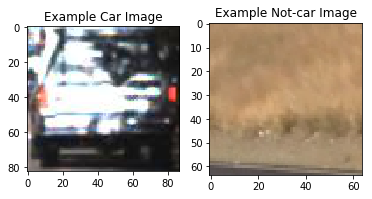

In [2]:
def display_random_images(cars, not_cars):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(not_cars))

    img_reader, img_params = cars[car_ind]
    car_image = img_reader(img_params)

    img_reader, img_params = not_cars[notcar_ind]
    notcar_image = img_reader(img_params)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

    
def load_labeled_images(cars=[], not_cars=[]):
    def img_reader(img_path):
        return mpimg.imread(img_path)
        
    images = glob.glob('data/*/*/*/*.png')
    for image in images:
        if 'non-vehicles' in image:
            not_cars.append( (img_reader, image) )
        else:
            cars.append( (img_reader, image) )
    
    return cars, not_cars


def load_annoted_driving_dataset1(cars=[], not_cars=[]):
    source_dir = ['data','object-detection-crowdai']
    def img_reader(img_params):
        xmin, ymin, xmax, ymax, Frame = img_params
        img = mpimg.imread(os.path.join(*source_dir, Frame))
        return img[ymin:ymax, xmin:xmax] #cv2.resize(img[ymin:ymax, xmin:xmax], (64,64))
    
    discarded = 0
    with open(os.path.join(*source_dir, 'labels.csv'), newline='') as f:
        reader = csv.DictReader(f, delimiter=',', quoting=csv.QUOTE_NONE)
        for row in reader:
            xmin, ymin, xmax, ymax, Frame, Label = row['xmin'], row['xmax'], row['ymin'], row['ymax'], row['Frame'], row['Label']
            xmin, ymin, xmax, ymax = tuple(map(int, (xmin, ymin, xmax, ymax)))
            
            if xmin >= xmax or ymin >= ymax:
                discarded += 1
                continue
            
            if Label.lower() == 'car':
                cars.append( (img_reader, (xmin, ymin, xmax, ymax, Frame)) )
            else:
                not_cars.append( (img_reader, (xmin, ymin, xmax, ymax, Frame)) )
    
    print("In object-detection-crowdai: ", discarded, " discarded")
    return cars, not_cars


def load_annoted_driving_dataset2(cars=[], not_cars=[]):
    source_dir = ['data','object-dataset']
    def img_reader(img_params):
        xmin, xmax, ymin, ymax, Frame = img_params
        img = mpimg.imread(os.path.join(*source_dir, Frame))
        return cv2.resize(img[ymin:ymax, xmin:xmax], (64,64))
    
    discarded = 0
    with open(os.path.join(*source_dir, 'labels.csv'), newline='') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_MINIMAL)
        # frame xmin ymin xmax ymax occluded label attributes(Only appears on traffic lights)
        for row in reader:
            frame, xmin, ymin, xmax, ymax, occluded, label = row[0], row[1], row[2], row[3], row[4], row[5], row[6]
            xmin, xmax, ymin, ymax = tuple(map(int, (xmin, xmax, ymin, ymax)))
            
            if xmin >= xmax or ymin >= ymax:
                discarded += 1
                continue
            
            if label.lower() == 'car':
                cars.append( (img_reader, (xmin, xmax, ymin, ymax, frame)) )
            else:
                not_cars.append( (img_reader, (xmin, xmax, ymin, ymax, frame)) )
    
    print("In object-dataset: ", discarded, " discarded")
    return cars, not_cars

cars, not_cars = load_labeled_images()
load_annoted_driving_dataset1(cars, not_cars)
load_annoted_driving_dataset2(cars, not_cars)

print('All images ...')
print('Number of \'car\' images:', len(cars))
print('Number of \'not car\' images:', len(not_cars))

display_random_images(cars, not_cars)

### b. Train a Linear SVM classifier

#### i. Extract HOG features

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, visualise=False, feature_vec=True):
    if visualise == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), 
                                  block_norm='L2-Hys', transform_sqrt=True, 
                                  visualise=visualise, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys', transform_sqrt=True, 
                       visualise=visualise, feature_vector=feature_vec)
        return features

# This function compute the HOG on the whole image.
def cvt_color(img, cspace='YCrCb'):
    color_cvt = {
        'HSV': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HSV),
        'LUV': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2LUV),
        'HLS': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HLS),
        'YUV': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YUV),
        'YCrCb': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb),
    }
    return color_cvt[cspace](img)

def extract_hog_features(image, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec=True):
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(image.shape[2]):
            hog_features.append(get_hog_features(image[:,:,channel], orient, pix_per_cell, cell_per_block, visualise=False, feature_vec=feature_vec))
            
        if feature_vec:
            hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, visualise=False, feature_vec=feature_vec)

    return hog_features
        


#### ii. Extract color features

In [ ]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

#### iii. Train a Linear SVM classifier    

In [ ]:
def extract_features_per_image(image, 
                               cspace, spatial_size, hist_bins, 
                               orient, pix_per_cell, cell_per_block, hog_channel, feature_vec,
                               resize=(64,64)):
    if cspace != 'RGB':
        image = cvt_color(image, cspace)
    
    hog_features = extract_hog_features(image, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec)
        
    image_shape = image.shape
    if image_shape[0] != resize[0] or image_shape[1] != resize[1]:
        resized = cv2.resize(image, resize)
    else:
        resized = image
        
    # Get color features
    spatial_features = bin_spatial(resized, size=spatial_size)
    hist_features = color_hist(resized, nbins=hist_bins)
        
    return np.hstack((spatial_features, hist_features, hog_features))

    
def extract_features(imgs, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec):
    features = []
    for img_reader, img_params in imgs:
        image = img_reader(img_params)
        features.append( extract_features_per_image(image, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec) )
    return features


def find_best_parameters(scaled_X, y):
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters)
    clf.fit(scaled_X, y)
    print(clf.best_params_)

    
def build_scaled_dataset(cars, notcars, cspace='YCrCb', spatial_size=(32, 32), hist_bins=32, orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channel="ALL", feature_vec=True):
    # HOG features
    car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, feature_vec=feature_vec)
    notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, feature_vec=feature_vec)
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)   
    
    # Scaled the dataset
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    # Build the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return scaled_X, y, X_scaler


def train_dataset(clf, scaled_X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=test_size, random_state=np.random.randint(0, 100))
    clf.fit(X_train, y_train)
    print(X_train.shape, y_train.shape)
    return round(clf.score(X_test, y_test), 4)


%time scaled_X, y, X_scaler = build_scaled_dataset(cars, not_cars)

svc = svm.LinearSVC()
%time test_accuracy = train_dataset(svc, scaled_X, y)

print('Test accuracy: ', test_accuracy)

## 2. Sliding window to search for vehicles 

In [ ]:
# Algo to find cars:
def pyramid(image, scale=1.5, min_size=(64, 64)):
    yield image
 
    while True:
        image = cv2.resize(image, (int(image.shape[1]/scale), int(image.shape[0]/scale)))
        
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
 
        yield image

def slide_window(img_shape, loc_start=(0,0), loc_stop=None, window_size=(64,64), strides=(16,16)):
    if loc_stop is None:
        loc_stop = (img[1], img[0])
    
    x, y = loc_start
    for y in range(y, img_shape[0], strides[1]):
        for x in range(x, img_shape[1], strides[0]):
            yield ((x, y), (x+window_size[0], y+window_size[1]))
   

def find_cars(img, ystart, ystop, 
              scale, svc, X_scaler, 
              cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window_in_cells=8):
    bboxes = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cvt_color(img_tosearch, cspace=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    if nxblocks <= 0 or nyblocks <= 0:
        return None
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = window_in_cells * pix_per_cell
    nblocks_per_window = ((window // pix_per_cell) - cell_per_block) + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute HOG features for the entire image
    hogs = extract_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, hog_channel="ALL", feature_vec=False)
    
    for yb in range(nysteps):
        for xb in range(nxsteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hogs_per_ch = [hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() for hog in hogs]
            hog_features = np.hstack(hogs_per_ch)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = int(svc.predict(test_features)[0])
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append( ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) )
                
    return bboxes


def draw_boxes(img, scale=1.5, with_heatmap=False):
    def add_heat(heatmap, boxes):
        for box in boxes:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        return heatmap
    
    def apply_threshold(heatmap, threshold):
        heatmap[heatmap <= threshold] = 0
        return heatmap
    
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    boxes = []
    multiplicator = 1
    for resized in pyramid(img, scale=scale):
        ystart= int(400 / multiplicator)
        ystop = int(656 / multiplicator)
        
        bboxes = find_cars(resized, ystart, ystop, multiplicator, svc, X_scaler,
                            cspace='YCrCb', orient = 9, pix_per_cell = 8, cell_per_block = 2, spatial_size=(32,32), hist_bins=32)
        
        if bboxes is not None:
            boxes.extend( bboxes )
        
        multiplicator = multiplicator*scale
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if with_heatmap:
        return draw_img, heatmap
    else:
        return draw_img
    
def show_img_heatmap(img, heatmap):
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')

img = mpimg.imread('test_images/test1.jpg')    
draw_img, heatmap = draw_boxes(img, with_heatmap=True)
show_img_heatmap(draw_img, heatmap)


## 3. Apply vehicle detection pipeline to videos

In [ ]:
def process_save_video(project_input, project_output, process_img_fct):
    clip1 = VideoFileClip(project_input)
    project_clip = clip1.fl_image(process_img_fct) 

    %time project_clip.write_videofile(project_output, audio=False)